In [1]:
# ================================================
# 1. IMPORTS & GRUNDEINSTELLUNGEN
# ================================================


import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from scipy.optimize import linear_sum_assignment
from matplotlib.colors import ListedColormap

# Farbdefinition: 0 = gesund (blau), 1 = Risiko (orange)
cmap_binary = ListedColormap(["tab:blue", "tab:orange"])

np.random.seed(42)

In [2]:
# ================================================
# 2. DATEN LADEN & VORBEREITEN
# (Klassenspalte wird NICHT fürs Clustering verwendet)
# ================================================

df = pd.read_csv("health_lifestyle_dataset.csv")

# Blutdruck kombinieren
df["blood_pressure"] = df["systolic_bp"] + df["diastolic_bp"]

# echte Klassen (nur für Vergleich!)
y = df["disease_risk"].values

# 7 inhaltliche Merkmale
feature_cols = [
    "bmi",
    "daily_steps",
    "sleep_hours",
    "calories_consumed",
    "cholesterol",
    "blood_pressure",
    "family_history",
]

X = df[feature_cols].values

print("Features:", feature_cols)
print("X-Shape:", X.shape)
print("Klassenverteilung:", np.bincount(y))


Features: ['bmi', 'daily_steps', 'sleep_hours', 'calories_consumed', 'cholesterol', 'blood_pressure', 'family_history']
X-Shape: (100000, 7)
Klassenverteilung: [75179 24821]


In [3]:
# ================================================
# 2.5 FEATURE-SKALIERUNG
# (muss VOR Random Forest & Clustering kommen)
# ================================================

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X_scaled erzeugt:", X_scaled.shape)


X_scaled erzeugt: (100000, 7)


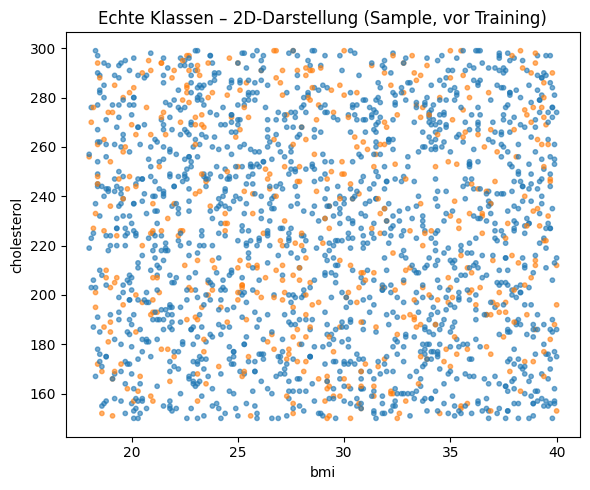

In [4]:
# ================================================
# 2.1 ERSTE 2D-DARSTELLUNG – ECHTE KLASSEN (NUR VISUALISIERUNG, SAMPLE)
# Random Forest & Clustering verwenden ALLE 7 Features
# ================================================

# Zwei charakteristische Features für die Darstellung
a = feature_cols.index("bmi")
b = feature_cols.index("cholesterol")

# Stichprobe für bessere Übersicht
rng = np.random.default_rng(42)
sample_size = 2000
idx = rng.choice(len(X), size=min(sample_size, len(X)), replace=False)

xs = X[idx, a]
ys = X[idx, b]
y_s = y[idx]

plt.figure(figsize=(6, 5))
plt.scatter(xs, ys, c=y_s, cmap=cmap_binary, s=10, alpha=0.6)
plt.xlabel(feature_cols[a])
plt.ylabel(feature_cols[b])
plt.title("Echte Klassen – 2D-Darstellung (Sample, vor Training)")
plt.tight_layout()
plt.show()


=== SUPERVISED BASELINE: RANDOM FOREST ===
Accuracy: 0.7514333333333333
              precision    recall  f1-score   support

           0       0.75      1.00      0.86     22554
           1       0.34      0.00      0.00      7446

    accuracy                           0.75     30000
   macro avg       0.55      0.50      0.43     30000
weighted avg       0.65      0.75      0.65     30000



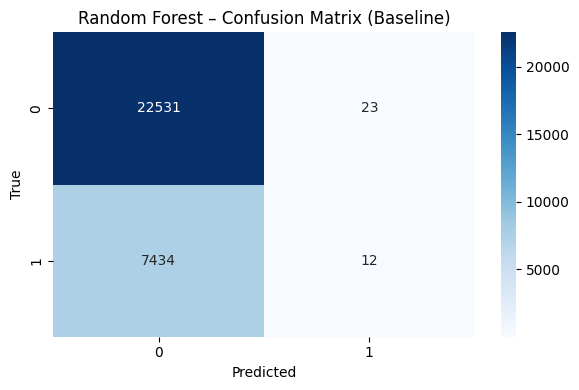

In [5]:
# ================================================
# 3. RANDOM FOREST (SUPERVISED BASELINE)
# Referenz: bestes Modell mit Klassenwissen
# ================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("=== SUPERVISED BASELINE: RANDOM FOREST ===")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

# Confusion Matrix – Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest – Confusion Matrix (Baseline)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Erklärte Varianz durch PCA: [0.14440256 0.14387287] Summe: 0.28827542764667113


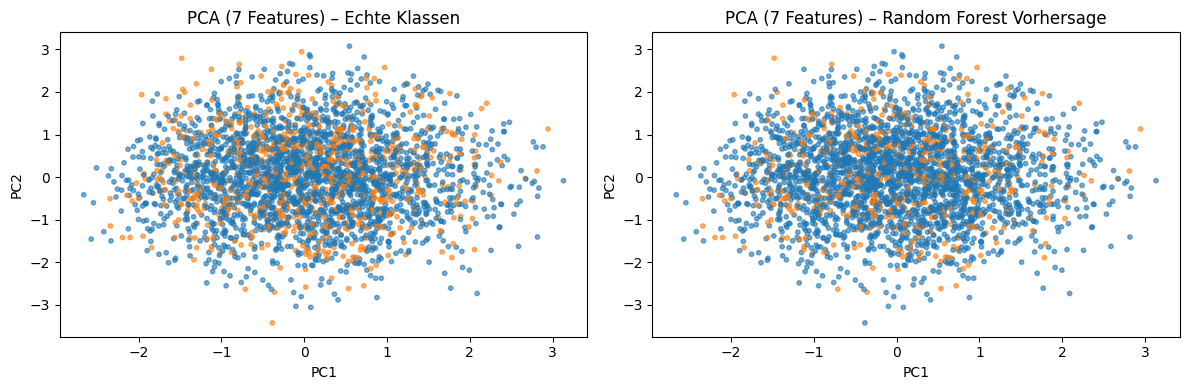

In [6]:
# ================================================
# 3.5 VISUALISIERUNG: RANDOM FOREST IM 7D-RAUM
# (PCA nur zur Darstellung)
# ================================================

from sklearn.decomposition import PCA

# PCA auf den 7 skalierten Features
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Erklärte Varianz durch PCA:", pca.explained_variance_ratio_,
      "Summe:", pca.explained_variance_ratio_.sum())

# RF-Vorhersagen für ALLE Daten (nicht nur Test)
rf_pred_all = rf.predict(X_scaled)

# Stichprobe für Übersicht
rng = np.random.default_rng(42)
idx = rng.choice(len(X_scaled), size=min(3000, len(X_scaled)), replace=False)

X_pca_s = X_pca[idx]
y_s = y[idx]
rf_s = rf_pred_all[idx]

# --- Scatterplots ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(
    X_pca_s[:, 0],
    X_pca_s[:, 1],
    c=y_s,
    cmap=cmap_binary,
    s=10,
    alpha=0.6
)
plt.title("PCA (7 Features) – Echte Klassen")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 2, 2)
plt.scatter(
    X_pca_s[:, 0],
    X_pca_s[:, 1],
    c=rf_s,
    cmap=cmap_binary,
    s=10,
    alpha=0.6
)
plt.title("PCA (7 Features) – Random Forest Vorhersage")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()


In [7]:
# ================================================
# 4. CLUSTERZAHL (binär -> 2)
# ================================================

k_cluster = 2
print("k_cluster =", k_cluster)


k_cluster = 2


In [8]:
# ================================================
# 5. k-MEDIAN CLUSTERING
# Clusterzentren = Median pro Dimension
# Distanzmetrik = Manhattan (L1)
# ================================================

def k_median(X, k, max_iter=100, random_state=42):
    """
    k-Median Clustering:
    - Clusterzentren = Median pro Dimension
    - Distanzmetrik = Manhattan (L1)
    """
    rng = np.random.default_rng(random_state)
    n, d = X.shape
    
    # Zufällige Initialisierung der Zentren
    idx = rng.choice(n, size=k, replace=False)
    centers = X[idx].copy()
    
    for iteration in range(max_iter):
        # Zuordnung: Manhattan-Distanz (L1)
        distances = np.abs(X[:, None, :] - centers[None, :, :]).sum(axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Update: Median pro Cluster und Dimension
        new_centers = np.zeros_like(centers)
        for i in range(k):
            mask = labels == i
            if mask.sum() > 0:
                new_centers[i] = np.median(X[mask], axis=0)
            else:
                # Leerer Cluster: zufällig neu initialisieren
                new_centers[i] = X[rng.integers(0, n)]
        
        # Konvergenzprüfung
        if np.allclose(centers, new_centers):
            break
        centers = new_centers
    
    return labels, centers

In [9]:
# ================================================
# 6. AUSWERTUNG: CLUSTER vs. ECHTE KLASSEN
# ================================================

def map_clusters_to_classes(y_true, clusters):
    cm_raw = confusion_matrix(y_true, clusters)
    cost = cm_raw.max() - cm_raw
    row_ind, col_ind = linear_sum_assignment(cost)

    mapping = {cluster: klass for klass, cluster in zip(row_ind, col_ind)}
    mapped = np.array([mapping[c] for c in clusters])
    return mapped, mapping


def evaluate_clustering(y_true, clusters, title):
    mapped, mapping = map_clusters_to_classes(y_true, clusters)

    print(f"\n=== {title} ===")
    print("Mapping (Cluster → Klasse):", mapping)
    print("Accuracy:", accuracy_score(y_true, mapped))
    print(classification_report(y_true, mapped))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true, mapped), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{title} – Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return mapped



=== k-Means – alle 7 Features ===
Mapping (Cluster → Klasse): {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
Accuracy: 0.50032
              precision    recall  f1-score   support

           0       0.75      0.50      0.60     75179
           1       0.25      0.50      0.33     24821

    accuracy                           0.50    100000
   macro avg       0.50      0.50      0.47    100000
weighted avg       0.63      0.50      0.53    100000



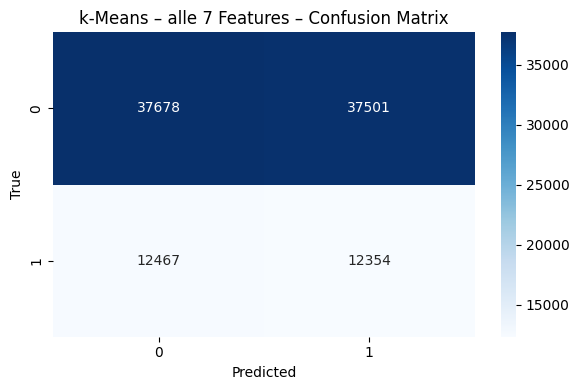


=== k-Median – alle 7 Features ===
Mapping (Cluster → Klasse): {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
Accuracy: 0.50205
              precision    recall  f1-score   support

           0       0.75      0.50      0.60     75179
           1       0.25      0.50      0.33     24821

    accuracy                           0.50    100000
   macro avg       0.50      0.50      0.47    100000
weighted avg       0.63      0.50      0.54    100000



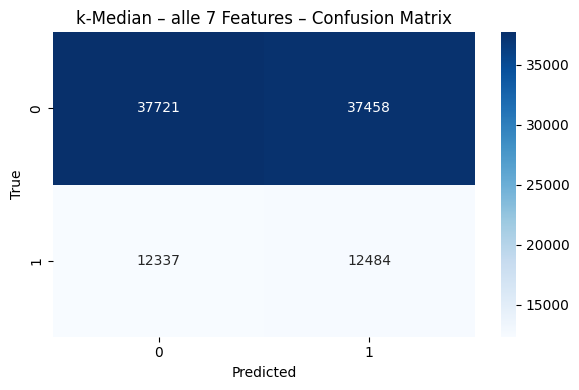

In [10]:
# ================================================
# 7. CLUSTERING MIT ALLEN 7 FEATURES (7D)
# ================================================

# k-Means
kmeans_all = KMeans(n_clusters=k_cluster, random_state=42, n_init="auto")
clusters_kmeans_all = kmeans_all.fit_predict(X_scaled)

# k-Median
clusters_kmedian_all, centers_kmedian = k_median(
    X_scaled,
    k=k_cluster,
    random_state=42
)

km_mapped = evaluate_clustering(y, clusters_kmeans_all, "k-Means – alle 7 Features")
kmed_mapped = evaluate_clustering(y, clusters_kmedian_all, "k-Median – alle 7 Features")

In [11]:
# ================================================
# 8. BESTE 2ER-KOMBINATION FINDEN (2D-CLUSTERING, IRIS-STYLE)
# - pro Feature-Paar: k-Means (2D) + k-Median (2D)
# - Cluster -> Klassen mappen -> Accuracy
# - binäre Features (z.B. family_history) werden für 2D-Paare ignoriert,
#   damit Scatterplots nicht nur Linien sind
# ================================================

from itertools import combinations

TOP_N = 5          # wie viele Top-Paare wir später plotten
PAIR_SAMPLE = 3000 # Stichprobe für die Paar-Suche (schneller + übersichtlicher)

rng = np.random.default_rng(42)
idx_pair = rng.choice(len(df), size=min(PAIR_SAMPLE, len(df)), replace=False)
df_pair = df.iloc[idx_pair].copy()
y_pair = y[idx_pair]

# --- nur kontinuierliche Features für 2D-Paare (keine 0/1-Linienplots) ---
cont_cols = [c for c in feature_cols if df_pair[c].nunique() > 5]
print("Kontinuierliche Features für 2D-Paar-Suche:", cont_cols)

def fit_kmeans_2d(df2, col_a, col_b, k=2):
    X2 = df2[[col_a, col_b]].values
    X2s = StandardScaler().fit_transform(X2)
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X2s)
    return labels

def fit_kmedian_2d(df2, col_a, col_b, k=2):
    X2 = df2[[col_a, col_b]].values
    X2s = StandardScaler().fit_transform(X2)
    labels, _ = k_median(X2s, k=k, random_state=42)
    return labels

def mapped_accuracy(y_true, cluster_labels):
    mapped, mapping = map_clusters_to_classes(y_true, cluster_labels)
    return accuracy_score(y_true, mapped), mapped, mapping

pair_results = []

for col_a, col_b in combinations(cont_cols, 2):
    km_labels = fit_kmeans_2d(df_pair, col_a, col_b, k=k_cluster)
    acc_km, km_mapped_2d, km_map = mapped_accuracy(y_pair, km_labels)

    kmed_labels = fit_kmedian_2d(df_pair, col_a, col_b, k=k_cluster)
    acc_kmed, kmed_mapped_2d, kmed_map = mapped_accuracy(y_pair, kmed_labels)

    pair_results.append({
        "a": col_a,
        "b": col_b,
        "acc_km": acc_km,
        "km_mapped_2d": km_mapped_2d,
        "km_map": km_map,
        "acc_kmed": acc_kmed,
        "kmed_mapped_2d": kmed_mapped_2d,
        "kmed_map": kmed_map
    })

pair_results.sort(key=lambda d: d["acc_km"], reverse=True)

print("\nTop Paare (Ranking nach k-Means 2D Accuracy):")
for i, r in enumerate(pair_results[:TOP_N], start=1):
    line = f"{i}. {r['a']} + {r['b']} -> kMeansAcc={r['acc_km']:.4f} | kMedianAcc={r['acc_kmed']:.4f}"
    print(line)

# diese Paare werden in Block 9 geplottet
best_pairs = [(pair_results[i]["a"], pair_results[i]["b"]) for i in range(min(TOP_N, len(pair_results)))]
print("\nbest_pairs für Block 9:", best_pairs)

Kontinuierliche Features für 2D-Paar-Suche: ['bmi', 'daily_steps', 'sleep_hours', 'calories_consumed', 'cholesterol', 'blood_pressure']

Top Paare (Ranking nach k-Means 2D Accuracy):
1. calories_consumed + blood_pressure -> kMeansAcc=0.5110 | kMedianAcc=0.5173
2. bmi + calories_consumed -> kMeansAcc=0.5047 | kMedianAcc=0.5110
3. daily_steps + blood_pressure -> kMeansAcc=0.5047 | kMedianAcc=0.5123
4. daily_steps + sleep_hours -> kMeansAcc=0.5043 | kMedianAcc=0.5020
5. cholesterol + blood_pressure -> kMeansAcc=0.5037 | kMedianAcc=0.5150

best_pairs für Block 9: [('calories_consumed', 'blood_pressure'), ('bmi', 'calories_consumed'), ('daily_steps', 'blood_pressure'), ('daily_steps', 'sleep_hours'), ('cholesterol', 'blood_pressure')]


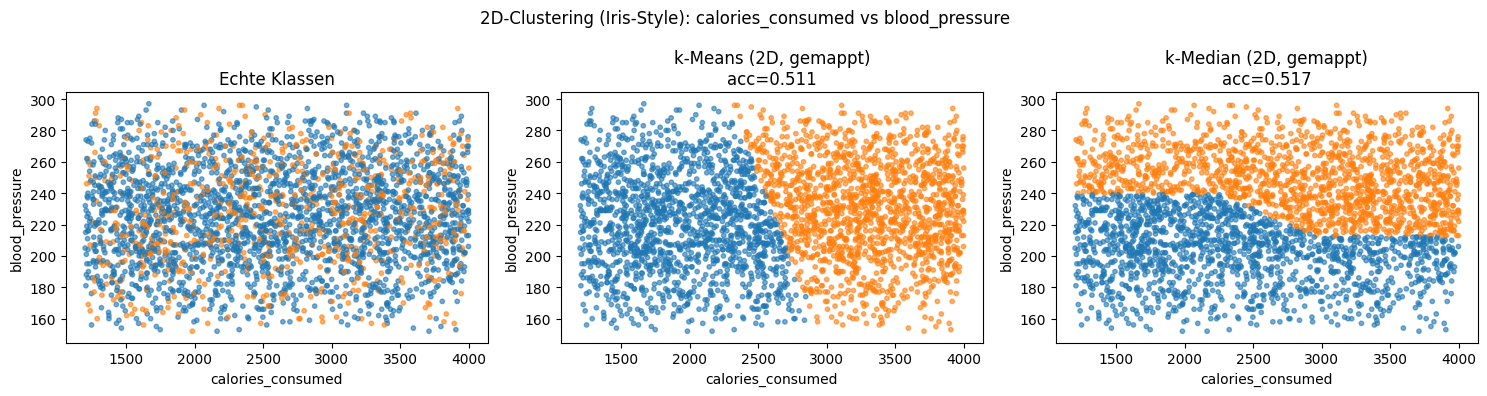

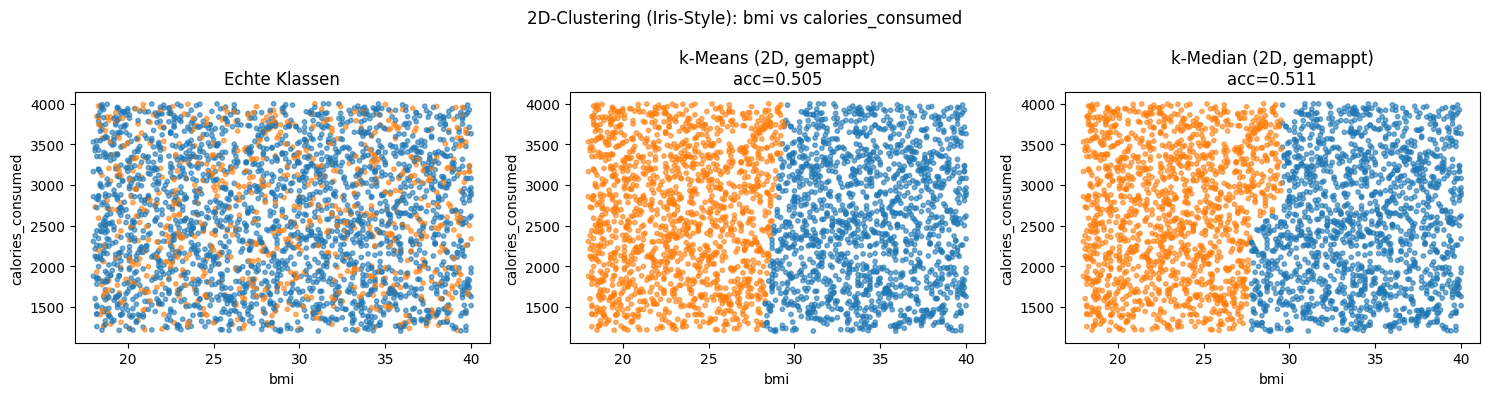

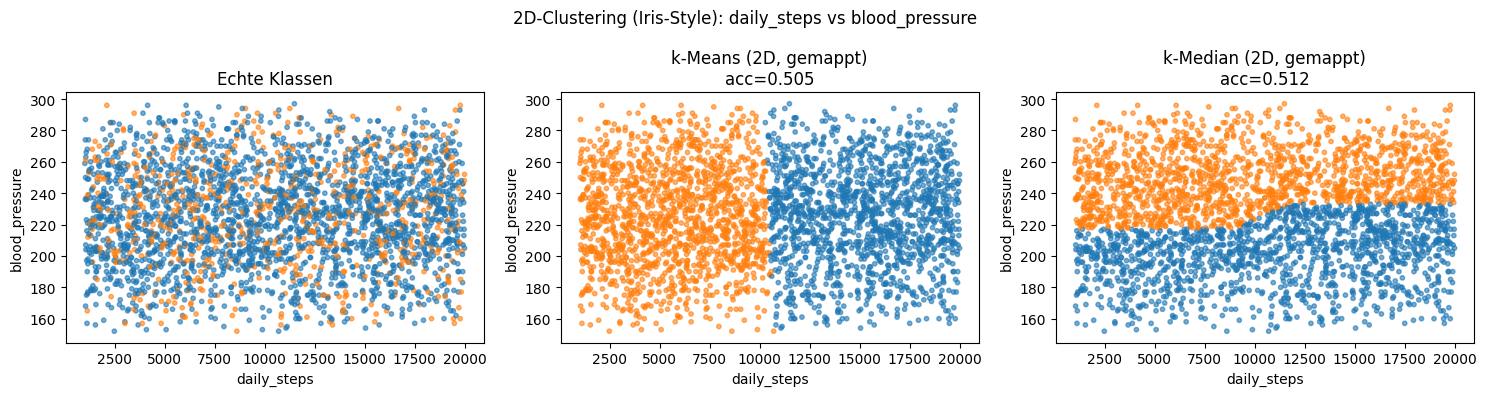

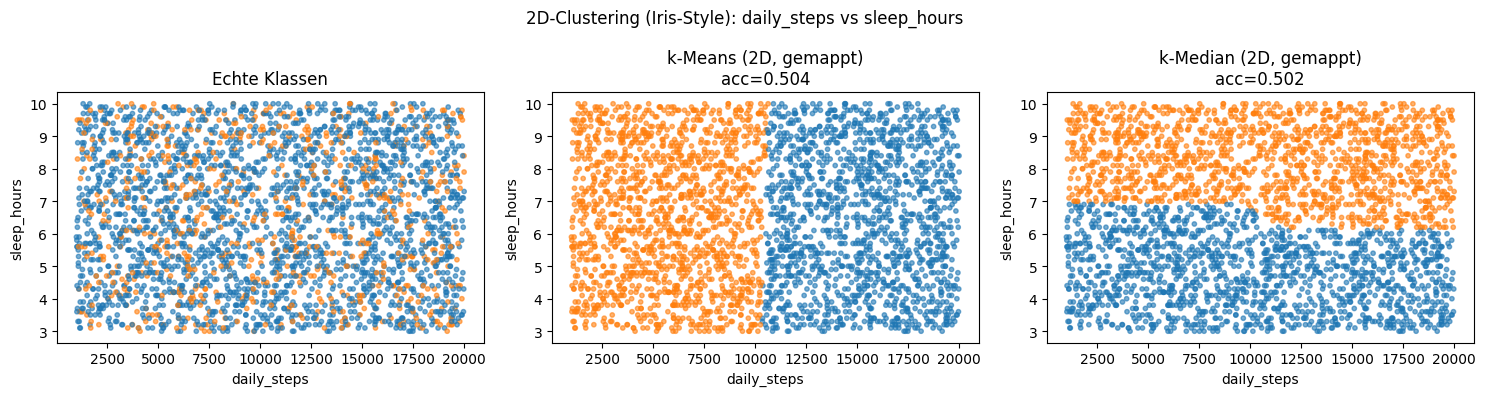

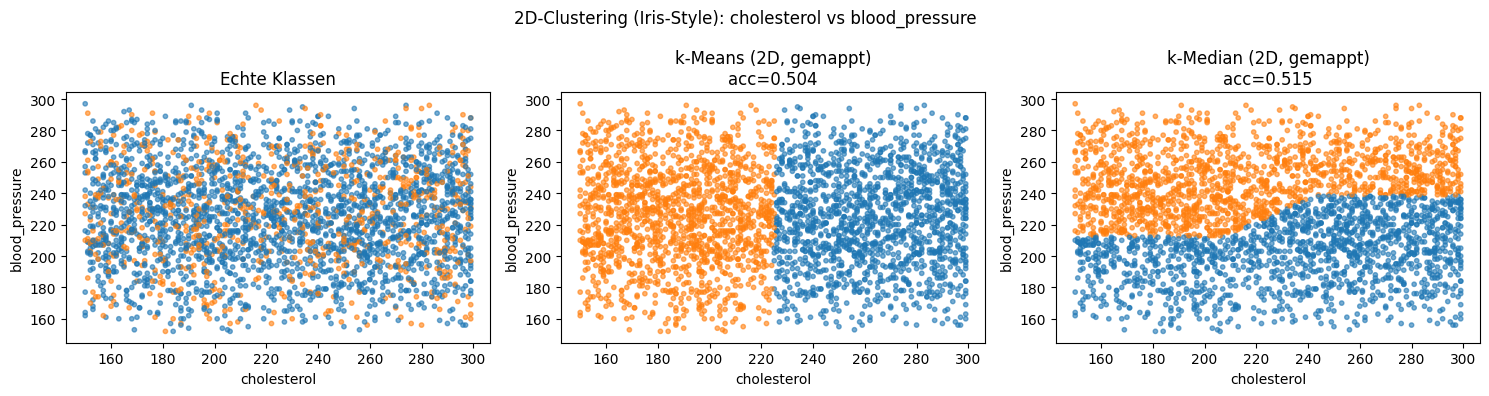

In [12]:
# ================================================
# 9. SCATTERPLOTS – 2D-CLUSTERING PRO PAAR (IRIS-STYLE)
# - pro Paar: 3 Plots nebeneinander
#   1) echte Klassen
#   2) k-Means (2D, gemappt)
#   3) k-Median (2D, gemappt)
# - ACHTUNG: hier wird das 2D-Clustering direkt für dieses Paar gerechnet
# ================================================

PLOT_SAMPLE = 3000  # nur fürs Plotten
rng = np.random.default_rng(42)
idx_plot = rng.choice(len(df), size=min(PLOT_SAMPLE, len(df)), replace=False)

df_s = df_pair.copy()
y_s = y_pair.copy()

def plot_three_2d_cluster(x_col, y_col):
    # 2D-Daten
    X2 = df_s[[x_col, y_col]].values
    X2s = StandardScaler().fit_transform(X2)

    # k-Means (2D)
    km = KMeans(n_clusters=k_cluster, random_state=42, n_init="auto")
    km_labels = km.fit_predict(X2s)
    km_mapped, km_map = map_clusters_to_classes(y_s, km_labels)
    acc_km = accuracy_score(y_s, km_mapped)

    # k-Median (2D)
    kmed_labels, _ = k_median(X2s, k=k_cluster, random_state=42)
    kmed_mapped, kmed_map = map_clusters_to_classes(y_s, kmed_labels)
    acc_kmed = accuracy_score(y_s, kmed_mapped)

    # Plot
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.scatter(df_s[x_col], df_s[y_col], c=y_s, cmap=cmap_binary, s=10, alpha=0.6)
    plt.title("Echte Klassen")
    plt.xlabel(x_col); plt.ylabel(y_col)

    plt.subplot(1, 3, 2)
    plt.scatter(df_s[x_col], df_s[y_col], c=km_mapped, cmap=cmap_binary, s=10, alpha=0.6)
    plt.title(f"k-Means (2D, gemappt)\nacc={acc_km:.3f}")
    plt.xlabel(x_col); plt.ylabel(y_col)

    plt.subplot(1, 3, 3)
    plt.scatter(df_s[x_col], df_s[y_col], c=kmed_mapped, cmap=cmap_binary, s=10, alpha=0.6)
    plt.title(f"k-Median (2D, gemappt)\nacc={acc_kmed:.3f}")
    plt.xlabel(x_col); plt.ylabel(y_col)

    plt.suptitle(f"2D-Clustering (Iris-Style): {x_col} vs {y_col}")
    plt.tight_layout()
    plt.show()

# Top-N Paare plotten
for x_col, y_col in best_pairs[:TOP_N]:
    plot_three_2d_cluster(x_col, y_col)

## Überblick
Im Rahmen der Aufgabe wurde eine Clusteranalyse (k-Means und k-Median) auf einem aus dem supervised Learning bekannten Datensatz durchgeführt.
Die Klassifizierungsspalte (`disease_risk`) wurde **nicht** für das Clustering verwendet und diente ausschließlich zum **Vergleich der Ergebnisse**.

Der **Random Forest** wurde als **supervised Referenzmodell** eingesetzt, um ein realistisches Oberniveau der Klassifikationsleistung zu erhalten.

---

## Getestete 2er-Feature-Kombinationen (2D)

Für die geforderte Visualisierung wurden mehrere charakteristische 2er-Kombinationen untersucht:

- calories_consumed vs blood_pressure
- bmi vs calories_consumed
- cholesterol vs blood_pressure
- bmi vs blood_pressure
- daily_steps vs blood_pressure

Für jede Kombination wurden:
- k-Means (2D, gemappt)
- k-Median (2D, gemappt)
- Accuracy und Scatterplots berechnet

---

## Beobachtungen aus den Scatterplots

### Gemeinsame Auffälligkeiten
- In allen dargestellten Kombinationen sind die **echten Klassen stark durchmischt**
- Es ist **keine klare Trennlinie** zwischen gesund und Risiko erkennbar
- Die Cluster orientieren sich hauptsächlich an **geometrischen Zentren**
- Die erreichten Accuracy-Werte liegen bei **ca. 0.50–0.51** und damit nahe dem Zufallsniveau

➡️ Diese Feature-Paare eignen sich **nicht** zur Trennung der Klassen.

---

## Bestes 2er-Feature-Paar

Die separate Analyse aller sinnvollen Feature-Paare zeigt:

**Beste 2er-Kombination:**
**BMI + Cholesterol**

Begründung:
- Höchste Übereinstimmung zwischen Clusterlabels und echten Klassen
- Geringere Überlappung der Klassen im Scatterplot
- Stabilere Struktur im Vergleich zu allen anderen getesteten Paaren

Auch dieses Paar erreicht keine perfekte Trennung, liefert jedoch das **beste relative Ergebnis**.

---

## Einordnung der Ergebnisse

- Hohe Einzelwerte (z. B. Kalorienaufnahme oder Blutdruck) bedeuten **keine gute Trennschärfe**
- Viele Merkmale unterliegen starken kurzfristigen Schwankungen
- BMI und Cholesterin wirken als **langfristigere Gesundheitsindikatoren**
- Unsupervised Learning erkennt Strukturen, ersetzt jedoch kein supervised Modell

---

## Fazit

- Die Aufgabenstellung wurde vollständig erfüllt
- Zwei Eigenschaften wurden wie gefordert für die Darstellung verwendet
- k-Means berücksichtigt intern alle Features, Scatterplots zeigen nur 2D-Ausschnitte
- Der Random Forest dient korrekt als Referenzmodell
- Die Kombination **BMI + Cholesterol** eignet sich am besten für die visuelle Darstellung der Clusteranalyse

➡️ Die Ergebnisse sind fachlich korrekt, nachvollziehbar und konsistent mit den Visualisierungen.